<a href="https://colab.research.google.com/github/katarinagresova/ia161/blob/main/Named_Entity_Recognition/IA161_Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition for Czech with Neural Networks and Pretrained Word Embeddings

In this session, we will train our own named entity recognizer.

We will use the FastText model for Czech and the CNEC corpus.

## FastText

FastText is a pretrained model that uses subword information. The advantage is that it assigns a vector to every sequence, so we do not have to tackle with the out-of-vocabulary (OOV problem). The downside is the size of the model.

https://fasttext.cc/docs/en/crawl-vectors.html

**Note for advanced students:** During training, we take only a small subset of FastText and do not bring the whole model into our NER model. This means, we do not use the advantage of the subword feature at prediction time. To solve this problem, we could do the following:

1. remove the Embedding layer
1. use the array of token embeddings as the input

It makes the code slightly less readable and it makes the preprocessing of input examples slightly more complicated. You can implement it on your own.

## CNEC

Czech Corpus of Named Entities (https://ufal.mff.cuni.cz/cnec/cnec2.0) contains ~ 10,000 documents (usually short sentences) and a two-level classification. For the purpose of this workshop, we simplify drastically the annotation.
1. We completely omit the nested annotations
1. We remove some annotations (such as capitalizations)
1. We merge many annotations to have only a few possible NER tags.
1. We add the IOB schema to the annotations.

## SumeCzech-NER

Another option is to use the SumeCzech corpus together with annotations. Since it contains one million articles, the results are more promising. Moreover, the annotation of SumeCzech-NER follows already the IOB schema.

Some other useful links:

https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54

https://docs.python.org/3/library/xml.etree.elementtree.html

https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede


## Install FastText and download data

In [1]:
!pip install fasttext

     |████████████████████████████████| 68 kB 4.6 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3119462 sha256=73aa4928c37debe803d57b292912982477b1916b0d7ad21e004530f10d1d48dc
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [2]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.cs.300.bin.gz
!gunzip cc.cs.300.bin.gz

--2021-10-06 10:47:58--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.cs.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4502843070 (4.2G) [application/octet-stream]
Saving to: ‘cc.cs.300.bin.gz’

cc.cs.300.bin.gz    100%[===================>]   4.19G  12.6MB/s    in 5m 41s  

2021-10-06 10:53:40 (12.6 MB/s) - ‘cc.cs.300.bin.gz’ saved [4502843070/4502843070]



In [3]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11858/00-097C-0000-0023-1B22-8{/Czech_Named_Entity_Corpus_2.0.zip}
!unzip Czech_Named_Entity_Corpus_2.0.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.2M  100 13.2M    0     0  6098k      0  0:00:02  0:00:02 --:--:-- 6098k
Archive:  Czech_Named_Entity_Corpus_2.0.zip
   creating: cnec2.0/
   creating: cnec2.0/data/
   creating: cnec2.0/data/plain/
  inflating: cnec2.0/data/plain/named_ent.txt  
  inflating: cnec2.0/data/plain/named_ent_dtest.txt  
  inflating: cnec2.0/data/plain/named_ent_etest.txt  
  inflating: cnec2.0/data/plain/named_ent_train.txt  
   creating: cnec2.0/data/xml/
  inflating: cnec2.0/data/xml/named_ent.xml  
  inflating: cnec2.0/data/xml/named_ent_dtest.xml  
  inflating: cnec2.0/data/xml/named_ent_etest.xml  
  inflating: cnec2.0/data/xml/named_ent_train.xml  
   creating: cnec2.0/data/treex/
  inflating: cnec2.0/data/treex/named_ent.treex  
  inflating: cnec2.0/data/treex/named_ent_dtest.treex  
  inflating: cnec2.0/data/treex/named_ent_etest.treex  

In [4]:
FASTTEXT_MODEL = 'cc.cs.300.bin'
NER_CORPUS = 'cnec2.0/data/treex/named_ent.treex'

## Simplify the tags

Before proceeding, check the two-level annotation from the CNEC documentation and by observing some examples.

**TASK 1** Find example of a nested annotation. Find example of an annotation you would annotate in a different way.

In [11]:
SIMPLIFICATION_DICT1 = {'P': 'PER', 'ps': 'PER', 'pf': 'PER', 'p_': 'PER', 'pc': 'PER', 'pp': 'PER', 'pd': 'PER', 'pm': 'PER',
                       'G': 'LOC', 'gu': 'LOC', 'gs': 'LOC', 'gc': 'LOC', 'gh': 'LOC', 'gq': 'LOC', 'gl': 'LOC', 'gr': 'LOC', 'gt': 'LOC', 'g_': 'LOC',
                       'I': 'ORG', 'if': 'ORG', 'i_': 'ORG', 'ia': 'ORG', 'ic': 'ORG', 'io': 'ORG',
                       'O': 'ART', 'oa': 'ART', 'or': 'ART', 'om': 'ART', 'oe': 'ART', 'o_': 'ART', 'op': 'ART',
                       'A': 'ADDR', 'ah': 'ADDR', 'az': 'ADDR', 'a_': 'ADDR', 'at': 'ADDR',
                       'M': 'MEDIA', 'me': 'MEDIA', 'mi': 'MEDIA', 'm_': 'MEDIA', 'mn': 'MEDIA', 'ms': 'MEDIA', 
                       'N': 'NUM', 'na': 'NUM', 'nb': 'NUM', 'nc': 'NUM', 'n_': 'NUM', 'ni': 'NUM', 'ns': 'NUM', 'no': 'NUM',
                       'T': 'TIME', 'td': 'TIME', 'tm': 'TIME', 'ty': 'TIME', 'tf': 'TIME', 't_': 'TIME', 'th': 'TIME',
                       '?': 'O', 'cap': 'O', 'lower': 'O', 'upper': 'O', 'f': 'FOREIGN', 'segm': 'O', 's': 'ABBR', 'C': 'BIB'}

SIMPLIFICATION_DICT2 = {'P': 'PER', 'ps': 'PER', 'pf': 'PER', 'p_': 'PER', 'pc': 'PER', 'pp': 'PER', 'pd': 'PER', 'pm': 'PER',
                       'G': 'LOC', 'gu': 'LOC', 'gs': 'LOC', 'gc': 'LOC', 'gh': 'LOC', 'gq': 'LOC', 'gl': 'LOC', 'gr': 'LOC', 'gt': 'LOC', 'g_': 'LOC',
                       'I': 'ORG', 'if': 'ORG', 'i_': 'ORG', 'ia': 'ORG', 'ic': 'ORG', 'io': 'ORG',
                       'O': 'O', 'oa': 'O', 'or': 'O', 'om': 'O', 'oe': 'O', 'o_': 'O', 'op': 'O',
                       'A': 'O', 'ah': 'O', 'az': 'O', 'a_': 'O', 'at': 'O',
                       'M': 'O', 'me': 'O', 'mi': 'O', 'm_': 'O', 'mn': 'O', 'ms': 'O', 
                       'N': 'O', 'na': 'O', 'nb': 'O', 'nc': 'O', 'n_': 'O', 'ni': 'O', 'ns': 'O', 'no': 'O',
                       'T': 'O', 'td': 'O', 'tm': 'O', 'ty': 'O', 'tf': 'O', 't_': 'O', 'th': 'O',
                       '?': 'O', 'cap': 'O', 'lower': 'O', 'upper': 'O', 'f': 'O', 'segm': 'O', 's': 'O', 'C': 'O'}                       

SIMPLIFICATION_DICT = {'P': 'PER', 'ps': 'PER', 'pf': 'PER', 'p_': 'PER', 'pc': 'PER', 'pp': 'PER', 'pd': 'PER', 'pm': 'PER',
                       'G': 'LOC', 'gu': 'LOC', 'gs': 'LOC', 'gc': 'LOC', 'gh': 'LOC', 'gq': 'LOC', 'gl': 'LOC', 'gr': 'LOC', 'gt': 'LOC', 'g_': 'LOC',
                       'I': 'ORG', 'if': 'ORG', 'i_': 'ORG', 'ia': 'ORG', 'ic': 'ORG', 'io': 'ORG',
                       'O': 'MISC', 'oa': 'MISC', 'or': 'MISC', 'om': 'MISC', 'oe': 'MISC', 'o_': 'MISC', 'op': 'MISC',
                       'A': 'MISC', 'ah': 'MISC', 'az': 'MISC', 'a_': 'MISC', 'at': 'MISC',
                       'M': 'MISC', 'me': 'MISC', 'mi': 'MISC', 'm_': 'MISC', 'mn': 'MISC', 'ms': 'MISC', 
                       'N': 'MISC', 'na': 'MISC', 'nb': 'MISC', 'nc': 'MISC', 'n_': 'MISC', 'ni': 'MISC', 'ns': 'MISC', 'no': 'MISC',
                       'T': 'MISC', 'td': 'MISC', 'tm': 'MISC', 'ty': 'MISC', 'tf': 'MISC', 't_': 'MISC', 'th': 'MISC',
                       '?': 'O', 'cap': 'O', 'lower': 'O', 'upper': 'O', 'f': 'MISC', 'segm': 'O', 's': 'MISC', 'C': 'O'}                                              

In [12]:
import numpy as np
import os, sys, re
import time
import fasttext
import logging
import xml.etree.ElementTree as ET
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

import matplotlib.pyplot as plt

In [13]:
 # This takes ~2 mins.
 %time embeddings = fasttext.load_model(FASTTEXT_MODEL)

CPU times: user 4.18 s, sys: 8.83 s, total: 13 s
Wall time: 3min 14s


## Parsing the CNEC
CNEC comes in several format. In this section, we parse the XML structure to obtain a simple format: token / annotation.

**Note for advanced students:** We extract also the lemma and POS tag, so you can experiment in your implementation with these additional features. 

In [14]:
tree = ET.parse(NER_CORPUS)
ns = {"pml":"http://ufal.mff.cuni.cz/pdt/pml/"}
root = tree.getroot()

In [15]:
sentences = root.find('pml:bundles', namespaces=ns).getchildren()
sentences[:2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  """Entry point for launching an IPython kernel.


[<Element '{http://ufal.mff.cuni.cz/pdt/pml/}LM' at 0x7f4e2afb5c50>,
 <Element '{http://ufal.mff.cuni.cz/pdt/pml/}LM' at 0x7f4e2af552f0>]

In [16]:
def parse_ne(ne): # either children or children/LM
  ner_dict = {}
  ne_type = ne.findall('./pml:ne_type', ns)
  ref = ne.findall('./pml:a.rf/pml:LM', ns)
  if not ref:
    ref = ne.findall('./pml:a.rf', ns)
  if ne_type and ref:
    for i, n in enumerate(ref):
      tag = SIMPLIFICATION_DICT.get(ne_type[0].text, ne_type[0].text)
      if tag != 'O':
        ner_dict[n.text] = ('B' if i==0 else 'I')+'-'+tag  # IOB markup - experiment with this
      else:
        ner_dict[n.text] = 'O'
  return ner_dict

def parse_tokens(tokens, ner): # the a_tree element
  ner_dict = {}
  for ne in ner.findall('./pml:children', ns):
      ner_dict = parse_ne(ne)
      if not ner_dict:
        for child in ne:
          ner_dict.update(parse_ne(child))
  token_dict = {}
  for token in tokens.findall('.//pml:LM', ns):
      token_dict[token.attrib.get('id')] = (token.find('pml:form', ns).text, token.find('pml:lemma', ns).text.split('_')[0].split('-')[0], token.find('pml:tag', ns).text[0])

  return [(t[0], t[1], t[2], 'O') if k not in ner_dict.keys() else (t[0], t[1], t[2], ner_dict[k]) for k, t in token_dict.items()] 

In [17]:
def parse_sentence(sentence): #
    tokens = sentence.find('.//pml:a_tree', namespaces=ns)
    ner = sentence.find('.//pml:n_tree', namespaces=ns)
    markup = parse_tokens(tokens, ner)
    return markup

markup = parse_sentence(sentences[10])
markup

[('Marně', 'marně', 'D', 'O'),
 ('pak', 'pak', 'D', 'O'),
 ('argumentoval', 'argumentovat', 'V', 'O'),
 (',', ',', 'Z', 'O'),
 ('že', 'že', 'J', 'O'),
 ('Jezevec', 'jezevec', 'N', 'B-PER'),
 ('tam', 'tam', 'D', 'O'),
 ('byl', 'být', 'V', 'O'),
 ('taky', 'také', 'D', 'O'),
 ('sám', 'sám', 'P', 'O'),
 (',', ',', 'Z', 'O'),
 ('málo', 'málo', 'D', 'O'),
 ('platné', 'platný', 'A', 'O'),
 (',', ',', 'Z', 'O'),
 ('Kája', 'Kája', 'N', 'B-PER'),
 ('a', 'a', 'J', 'O'),
 ('nebyl', 'být', 'V', 'O'),
 ('soudruh', 'soudruh', 'N', 'O'),
 ('Jezevec', 'jezevec', 'N', 'B-PER'),
 (',', ',', 'Z', 'O'),
 ('dozor', 'dozor', 'N', 'O'),
 ('z', 'z', 'R', 'O'),
 ('ministerstva', 'ministerstvo', 'N', 'O'),
 ('a', 'a', 'J', 'O'),
 ('příležitostný', 'příležitostný', 'A', 'O'),
 ('milenec', 'milenec', 'N', 'O'),
 ('Vavrouškové', 'Vavroušková', 'N', 'B-PER'),
 ('Miluše', 'Miluše', 'N', 'I-PER'),
 ('.', '.', 'Z', 'O')]

In [18]:
data = {}
markup = []
num = []
for i, sentence in enumerate(sentences):
  p = parse_sentence(sentence)
  markup += p
  num += ([i]*len(p))
data.update({'Sentence #': num, 'Word': [m[0] for m in markup], 'Lemma': [m[1] for m in markup], 'POS': [m[2] for m in markup], 'Tag': [m[3] for m in markup]})

In [19]:
df = pd.DataFrame(data)
df

,Sentence #,Word,Lemma,POS,Tag
0,0,Jste,být,V,O
1,0,světa,svět,N,O
2,0,znalý,znalý,A,O
3,0,muž,muž,N,O
4,0,a,a,J,O
...,...,...,...,...,...
200138,8992,psala,psát,V,O
200139,8992,Ellian,Ellian,X,B-PER
200140,8992,Mac,Macintosh,N,I-PER
200141,8992,Gregor,Gregor,N,I-PER


In [20]:
sentences = df["Sentence #"].values[-1] + 1

In [21]:
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = [''] + list(set(data['Word'].to_list()))
    elif token_or_tag == 'lemma':
        vocab = [''] + list(set(data['Lemma'].to_list()))
    elif token_or_tag == 'pos':
        vocab = [''] + list(set(data['POS'].to_list()))
    else:
        vocab = [''] + list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(df, 'token')
lemma2idx, idx2lemma = get_dict_map(df, 'lemma')
pos2idx, idx2pos = get_dict_map(df, 'pos')
tag2idx, idx2tag = get_dict_map(df, 'tag')

In [22]:
tag2idx

{'': 0,
 'B-LOC': 4,
 'B-MISC': 8,
 'B-ORG': 2,
 'B-PER': 7,
 'I-LOC': 5,
 'I-MISC': 1,
 'I-ORG': 6,
 'I-PER': 9,
 'O': 3}

In [23]:
df['Word_idx'] = df['Word'].map(token2idx)
df['Tag_idx'] = df['Tag'].map(tag2idx)
df['Lemma_idx'] = df['Lemma'].map(lemma2idx)
df['Pos_idx'] = df['POS'].map(pos2idx)

df

,Sentence #,Word,Lemma,POS,Tag,Word_idx,Tag_idx,Lemma_idx,Pos_idx
0,0,Jste,být,V,O,28150,3,6120,9
1,0,světa,svět,N,O,32298,3,19918,5
2,0,znalý,znalý,A,O,5861,3,3401,12
3,0,muž,muž,N,O,36851,3,21129,5
4,0,a,a,J,O,51066,3,29352,4
...,...,...,...,...,...,...,...,...,...
200138,8992,psala,psát,V,O,47677,3,9273,9
200139,8992,Ellian,Ellian,X,B-PER,30871,7,17649,6
200140,8992,Mac,Macintosh,N,I-PER,18817,9,25000,5
200141,8992,Gregor,Gregor,N,I-PER,4864,9,2845,5


In [24]:
# Fill na
df_fillna = df.fillna(method='ffill', axis=0)
# Groupby and collect columns
df_group = df_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx', 'Lemma_idx', 'Pos_idx'].agg(lambda x: list(x))
# Visualise data
df_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx,Lemma_idx,Pos_idx
0,0,"[Jste, světa, znalý, muž, a, víte, stejně, dob...","[V, N, A, N, J, V, D, D, J, P, Z, J, N, R, A, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[28150, 32298, 5861, 36851, 51066, 11802, 1048...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[6120, 19918, 3401, 21129, 29352, 5344, 6053, ...","[9, 5, 12, 5, 4, 9, 7, 7, 4, 10, 1, 4, 5, 8, 1..."
1,1,"[byl, z, toho, už, vzteklý, jak, uvázaný, pes,...","[V, R, P, D, A, J, A, N, Z, J, N, R, N, P, D, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[16371, 28760, 4837, 48912, 41486, 30100, 4582...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[6120, 16479, 25006, 28043, 23726, 17217, 2626...","[9, 8, 10, 7, 12, 4, 12, 5, 1, 4, 5, 8, 5, 10,..."
2,2,"[I, s, Dubenkou, ,, na, kterou, U, tygra, teď,...","[J, R, N, Z, R, P, R, N, D, V, Z, Z, Z]","[O, O, B-PER, O, O, O, B-ORG, I-ORG, O, O, O, ...","[31502, 25161, 3068, 6370, 30000, 23217, 11772...","[3, 3, 7, 3, 3, 3, 2, 6, 3, 3, 3, 3, 3]","[18237, 14460, 20771, 3709, 17162, 9645, 4705,...","[4, 8, 5, 1, 8, 10, 8, 5, 7, 9, 1, 1, 1]"
3,3,"[Hodil, si, kulovnici, přes, rameno, a, vydal,...","[V, P, N, R, N, J, V, P, R, A, A, N, R, N, Z, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1280, 17097, 6750, 35064, 30031, 51066, 23509...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[23386, 13555, 6092, 20121, 17180, 29352, 2252...","[9, 10, 5, 8, 5, 4, 9, 10, 8, 12, 12, 5, 8, 5,..."
4,4,"[Já, je, normálně, nosím, tak, "", -, a, ukázal...","[P, P, D, V, D, Z, Z, J, V, N, N, R, N, A, Z]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[34573, 20920, 2878, 45274, 14889, 10295, 3657...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[11681, 19072, 1693, 16291, 8609, 5938, 1, 293...","[10, 10, 7, 9, 7, 1, 1, 4, 9, 5, 5, 8, 5, 12, 1]"


## Know the data
CNEC is composed of 8992 documents (mostly sentences). Below you can see the length histogram (in number of tokens). Most documents have between 5 and 25 tokens.

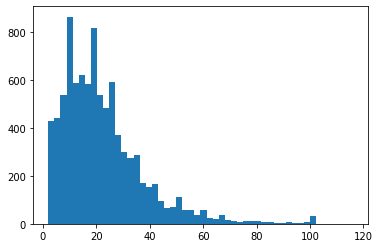

In [25]:
%matplotlib inline
plt.hist([len(s) for s in df_group['Word_idx']], bins=50) # sentence length histogram
plt.show()

## Train/Test Split
Although CNEC comes with split data, we decided to split it differently. The corpus is not big enough, so it's better not to use train / dev / test but only train / dev.

The output is categorical - it's a number, similar to POS - 1 is not better than 2. We need to encode such output as one-hot encoding. So, e.g. 2 is encoded as [0, 0, 1, 0, 0, 0, ... 0 ] where the length of the vector is the number of different possible categories (in our case, it depends on the level of simplification of the annotations). 

Since the input of a neural network is a matrix (list of example documents - sequences), we need all our data to be the same length.

We use padding for this and pad all examples with zeros to the length of the longest document.

In [26]:
def get_pad_train_dev(df_group, df):

    #Pad tokens (X var)    
    tokens = df_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in df_group['Word_idx']])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= token2idx[""])

    #Pad Tags (y var) and convert it into one hot encoding
    tags = df_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags_ = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train and dev set
    train_tokens, dev_tokens, train_tags, dev_tags = train_test_split(pad_tokens, pad_tags_, test_size = 0.1, train_size =0.9, random_state=42)

    print(
        'train_tokens length:', len(train_tokens),
        '\ndev_tokens length:', len(dev_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ndev_tags:', len(dev_tags),
    )
    
    return np.array(train_tokens), np.array(dev_tokens), np.array(train_tags), np.array(dev_tags)

train_tokens_, dev_tokens_, train_tags_, dev_tags_ = get_pad_train_dev(df_group, df)

train_tokens length: 8093 
dev_tokens length: 900 
train_tags: 8093 
dev_tags: 900


In [27]:
train_tokens_.shape, train_tags_.shape

((8093, 116), (8093, 116, 10))

This is how the data can be converted back to human-readable form.

In [28]:
[(idx2token[x], idx2tag[np.argmax(y)]) for x, y in zip(train_tokens_[103], train_tags_[103]) if idx2token[x]]

[('Nejžádanější', 'O'),
 ('knihy', 'O'),
 ('minulého', 'O'),
 ('týdne', 'O'),
 ('ve', 'O'),
 ('vybraných', 'O'),
 ('knihkupectvích', 'O'),
 ('v', 'O'),
 ('okresech', 'O'),
 ('Kroměříž', 'B-LOC'),
 (',', 'O'),
 ('Uherské', 'B-LOC'),
 ('Hradiště', 'I-LOC'),
 (',', 'O'),
 ('Vsetín', 'B-LOC'),
 ('a', 'O'),
 ('Zlín', 'B-LOC'),
 (':', 'O')]

Neural Network Parameters

In [29]:
input_dim = len(list(set(df['Word'].to_list())))+1 # vocab length + padding
output_dim = 64
input_length = train_tokens_.shape[1] # max example length
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  51082 
output_dim:  64 
input_length:  116 
n_tags:  10


In [30]:
# Prepare embedding matrix
hits = misses = 0 # in case of FastText all tokens should be covered
embedding_matrix = np.zeros((len(token2idx), embeddings.get_dimension()))
for word, i in token2idx.items():
    embedding_vector = embeddings[word]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 51082 words (0 misses)


## Neural Network Architecture

We use BiLSTM & LSTM with dropouts. You can experiment with this. A larger network does not always bring better results. 

For the output layer, we use softmax and categorical crossentropy loss - this is the most suitable setting for categorization tasks.

In the Embedding layer, we use the FastText weights as inputs. 

Since the sequences are padded with zeros, it is extremely easy for the net to learn these paddings. On the other hand, this information is not useful in the evaluation. For this reason, we use the masking of zeros, so they do not contribute to the evaluation calculation. (If you switch ``mask_zero`` to ``False``, your net will have 99% accuracy without being better than a masked net.


In [31]:
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=input_dim, output_dim=embeddings.get_dimension(), input_length=input_length, embeddings_initializer=Constant(embedding_matrix), trainable=True, mask_zero=True))
#model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, trainable=True, mask_zero=True))

model.add(Dropout(0.5))
# Add BiLSTM
model.add(Bidirectional(LSTM(units=output_dim*2, return_sequences=True), merge_mode = 'concat'))

model.add(Dropout(0.5))
model.add(LSTM(units=output_dim, return_sequences=True))

# Add timeDistributed Layer
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

#Optimiser 
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 300)          15324600  
_________________________________________________________________
dropout (Dropout)            (None, 116, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 116, 256)          439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 116, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 116, 64)           82176     
_________________________________________________________________
time_distributed (TimeDistri (None, 116, 10)           650       
Total params: 15,846,722
Trainable params: 15,846,722
Non-trainable params: 0
____________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


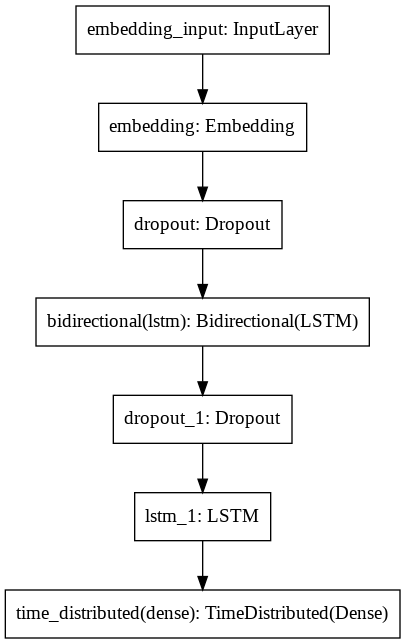

In [32]:
%matplotlib inline
results = pd.DataFrame()
plot_model(model)

## Setting the training parameters

It is difficult to set all the hyperparameters (parameters of the net + parameters of the training) to perform the best. However, what is worth trying:
1. learning rate: larger numbers can speed up the learning but also can cause divergence
1. number of epochs: If you observe val_loss/val_accuracy diverge - reduce the number of epochs to prevent overfitting. If the results are not good enough, try to increase the number of epochs - maybe the training didn't finish.
1. validation_split: Here, we would need more training examples (we observe a gap between accuracy and val_accuracy), so every example counts. Try increasing the number of training examples.

In [33]:
# Training: It takes several minutes.
hist = model.fit(train_tokens_, train_tags_, batch_size=64, verbose=1, epochs=5, validation_split=0.1)

Epoch 1/5
114/114 [==============================] - 179s 1s/step - loss: 0.1210 - accuracy: 0.8273 - val_loss: 0.0720 - val_accuracy: 0.8847
Epoch 2/5
114/114 [==============================] - 162s 1s/step - loss: 0.0524 - accuracy: 0.9116 - val_loss: 0.0530 - val_accuracy: 0.9152
Epoch 3/5
114/114 [==============================] - 162s 1s/step - loss: 0.0268 - accuracy: 0.9545 - val_loss: 0.0510 - val_accuracy: 0.9217
Epoch 4/5
114/114 [==============================] - 161s 1s/step - loss: 0.0169 - accuracy: 0.9717 - val_loss: 0.0546 - val_accuracy: 0.9249
Epoch 5/5
114/114 [==============================] - 164s 1s/step - loss: 0.0111 - accuracy: 0.9815 - val_loss: 0.0584 - val_accuracy: 0.9200


## Sample predictions on the train set

Below, you can see predictions on the train set. Not surprisingly, they are correct.

**TASK 2** Modify the code to display dev set predictions. Comment on what you see.

**OPTIONAL TASK** Evaluate the network on the dev set. What entities are easy to recognize? Which are hard?

In [35]:
def print_predictions(tokens, tags, count=10):
  i = 0

  for sample, annotation in zip(tokens, tags):
    ex=sample.reshape((1, sample.shape[0]))
    prediction = model.predict(ex)
    ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
    print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if idx2token[x]])
    i += 1
    if i == count:
      break

In [37]:
print("Predicting for train set")
print_predictions(train_tokens_, train_tags_, 10)
print("Predicting for test set")
print_predictions(dev_tokens_, dev_tags_, 10)

Predicting for train set
[('A', 'O', 'O'), ('s', 'O', 'O'), ('velkým', 'O', 'O'), ('zájmem', 'O', 'O'), ('si', 'O', 'O'), ('prohlížel', 'O', 'O'), (',', 'O', 'O'), ('jak', 'O', 'O'), ('slavná', 'O', 'O'), ('osoba', 'O', 'O'), ('před', 'O', 'O'), ('ním', 'O', 'O'), ('vypadá', 'O', 'O'), ('.', 'O', 'O')]
[('Ne', 'O', 'O'), (',', 'O', 'O'), ('to', 'O', 'O'), ('je', 'O', 'O'), ('špatná', 'O', 'O'), ('odpověď', 'O', 'O'), ('.', 'O', 'O')]
[('Jakmile', 'O', 'O'), ('se', 'O', 'O'), ('od', 'O', 'O'), ('něho', 'O', 'O'), ('dílo', 'O', 'O'), ('odpoutá', 'O', 'O'), (',', 'O', 'O'), ('dá', 'O', 'O'), ('znovu', 'O', 'O'), ('zaznít', 'O', 'O'), ('jen', 'O', 'O'), ('nepatrně', 'O', 'O'), ('utlumenému', 'O', 'O'), ('hlasu', 'O', 'O'), ('duše', 'O', 'O'), (',', 'O', 'O'), ('jež', 'O', 'O'), ('byla', 'O', 'O'), ('provždy', 'O', 'O'), ('zbavena', 'O', 'O'), ('naděje', 'O', 'O'), ('.', 'O', 'O')]
[('Takové', 'O', 'O'), ('umytí', 'O', 'O'), ('čas', 'O', 'O'), ('od', 'O', 'O'), ('času', 'O', 'O'), ('neškodí

In [42]:
def print_wrong_predictions(tokens, tags, count=10):
  i = 0

  for sample, annotation in zip(tokens, tags):
    ex=sample.reshape((1, sample.shape[0]))
    prediction = model.predict(ex)
    ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(sample)])
    print([(idx2token[x], idx2tag[np.argmax(y)], idx2tag[z]) for x, y, z in zip(sample, annotation, ner) if (idx2token[x] and idx2tag[np.argmax(y)] != idx2tag[z])])
    i += 1
    if i == count:
      break

In [43]:
print_wrong_predictions(dev_tokens_, dev_tags_, 10)

[('nepřáteli', 'O', 'I-MISC'), ('Írán', 'B-LOC', 'B-PER'), ('Chomejního', 'B-PER', 'O')]
[('TÁBOR', 'B-LOC', 'O')]
[]
[('cO2', 'B-MISC', 'O')]
[]
[('července', 'O', 'B-MISC')]
[]
[]
[]
[]


## Try on your own sentences

Some entities are easier to recognize than others.

**TASK 3** Experiment on sentences with different types of entities, OOVs etc. Comment on what you see.

In [38]:
my_sentence = "Ahoj , já jsem Pepa Tichošlápek z Brna ."
encoded = [token2idx.get(t, 0) for t in my_sentence.split()] + [0] * input_length
print("OOV:", [t for t in my_sentence.split() if t not in token2idx])
encoded = encoded[:input_length]

sample = np.array(encoded).reshape((1, input_length))
prediction = model.predict(sample)
ner = np.squeeze(np.argmax(prediction, axis=-1)[:len(my_sentence.split())])
print([(t, idx2tag[n]) for t, n in zip(my_sentence.split(), ner)])

OOV: ['Tichošlápek']
[('Ahoj', 'O'), (',', 'O'), ('já', 'O'), ('jsem', 'O'), ('Pepa', 'B-PER'), ('Tichošlápek', 'B-PER'), ('z', 'O'), ('Brna', 'B-LOC'), ('.', 'O')]
